# Notebook to test the Carmack algorithm for the inverse problem

## Problem statement:
$f(p, \phi) = \int_{L(\mathbf{p})} \,g(r, \theta)$, find $g(r, \theta)$ from $f(p, \phi)$.

In [466]:
import numpy as np
from scipy.special import jn, jn_zeros, jv
from math import factorial as fact
π = np.pi
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
sns.set_style("darkgrid")  # adds seaborn style to charts, eg. grid
plt.style.use("dark_background")  # inverts colors to dark theme
plt.rcParams['font.family'] = 'monospace' 
plt.rcParams['axes.grid'] = True
plt.rcParams['image.cmap'] = 'plasma'
np.set_printoptions(precision=3) # set precision for printing numpy arrays
from tqdm import tqdm

In [467]:
data = np.load('data/data_clean.npy')
print(f'data: {data.dtype}')


data: [('label', '<U10'), ('shot', '<i4'), ('time', '<f4'), ('prel', '<f4', (92,)), ('data', '<f4', (92,)), ('data_err', '<f4', (92,)), ('target', '<f4', (21,)), ('emiss', '<f4', (110, 110)), ('x_emiss', '<f4', (110,)), ('y_emiss', '<f4', (110,)), ('majr', '<f4'), ('minr', '<f4'), ('b_tor', '<f4', (24,)), ('b_rad', '<f4', (24,)), ('phi_tor', '<f4', (24,))]


In [468]:
IDX = np.random.randint(0, 69352)
M = 2
L = 7
FINESSE = 110

In [469]:
#load data_clean.npy
d = np.load('data/data_clean.npy')
print(f'Keys in data: {d.dtype.names}')
sxr = d['data'][IDX]
emiss = d['emiss'][IDX]
bessel_coefss = d['target'][IDX]
xx_gt, yy_gt = np.meshgrid(d['x_emiss'][IDX], d['y_emiss'][IDX])
xy_gt = np.stack([xx_gt, yy_gt], axis=-1)
MAJR, MINR = d['majr'][IDX], d['minr'][IDX]
print(f'sxr: {sxr.shape}, emiss: {emiss.shape}, bessel_coefss: {bessel_coefss.shape}, xy_gt: {xy_gt.shape}')

Keys in data: ('label', 'shot', 'time', 'prel', 'data', 'data_err', 'target', 'emiss', 'x_emiss', 'y_emiss', 'majr', 'minr', 'b_tor', 'b_rad', 'phi_tor')
sxr: (92,), emiss: (110, 110), bessel_coefss: (21,), xy_gt: (110, 110, 2)


In [470]:
# #load data_clean.npz
# data = np.load('data/data_clean.npz')
# print(f'Keys in data: {data.files}')

# sxr = data['sxr'][IDX]
# emiss = data['emiss'][IDX]
# bessel_coefss = data['bessel_coefss'][IDX]
# xx_gt, yy_gt = np.meshgrid(data['x_emiss'][IDX], data['y_emiss'][IDX])
# xy_gt = np.stack([xx_gt, yy_gt], axis=-1)
# MAJR, MINR = data['majr'][IDX], data['minr'][IDX]
# print(f'sxr: {sxr.shape}, emiss: {emiss.shape}, bessel_coefss: {bessel_coefss.shape}, xy_gt: {xy_gt.shape}')


Bessel coeffs are 21, 3x7, because there are 2 coefss for cosine (0 and 1), both non-zero, and 1 for sine (1), bc the sine(0) is zero.

In [471]:
# a0cl, a1cl, a1sl = bessel_coefss[0:L], bessel_coefss[L:2*L], bessel_coefss[2*L:3*L]
a0c, a1c, a1s = bessel_coefss[0:L], bessel_coefss[L:2*L], bessel_coefss[2*L:3*L] 
a0s = np.zeros(L) #a0s = 0

a0, a1 = a0c + a0s *1j, a1c + a1s *1j # a0, a1 are complex numbers (see note below)

a = np.array([a0, a1], dtype=complex) # a is a MxL array of complex numbers

print(f'sxr.shape: {sxr.shape}')
print(f'emiss.shape: {emiss.shape}')
print(f'bessel_coefss.shape: {bessel_coefss.shape}')
print(f'a0c.shape: {a0c.shape}')
print(f'a0s.shape: {a0s.shape}')
print(f'a1c.shape: {a1c.shape}')
print(f'a1s.shape: {a1s.shape}')

#  print the actual values of the coefficients
print(f'a0c: {a0c}')
print(f'a0s: {a0s}')
print(f'a1c: {a1c}')
print(f'a1s: {a1s}')

# print complex numbers
print(f'a0: {a0}')
print(f'a1: {a1}')

# print the shape of the a array
print(f'a.shape: {a.shape}')


sxr.shape: (92,)
emiss.shape: (110, 110)
bessel_coefss.shape: (21,)
a0c.shape: (7,)
a0s.shape: (7,)
a1c.shape: (7,)
a1s.shape: (7,)
a0c: [ 61.087 -13.023  -4.497  12.738  -7.147   8.365   1.061]
a0s: [0. 0. 0. 0. 0. 0. 0.]
a1c: [-3.339e-15  4.395e+00 -4.298e+00 -2.219e+00  1.314e+00 -4.275e+00
  5.975e+00]
a1s: [-2.474e-16 -4.977e+00  6.911e+00 -4.836e+00 -3.712e-01 -5.989e+00
 -1.556e+00]
a0: [ 61.087+0.j -13.023+0.j  -4.497+0.j  12.738+0.j  -7.147+0.j   8.365+0.j
   1.061+0.j]
a1: [-3.339e-15-2.474e-16j  4.395e+00-4.977e+00j -4.298e+00+6.911e+00j
 -2.219e+00-4.836e+00j  1.314e+00-3.712e-01j -4.275e+00-5.989e+00j
  5.975e+00-1.556e+00j]
a.shape: (2, 7)


## Bessel functions

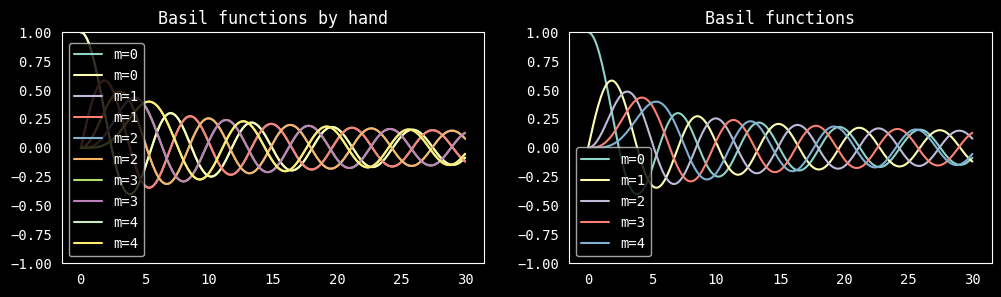

In [472]:
#bessel
def bes(m:int,x:np.ndarray):
    x_shape = x.shape
    return jv(m,x.reshape(-1)).reshape(x_shape)

# def bes_zeros(m:int,n:int):
#     bz = jn_zeros(m,n)
#     if m > 0: # jn does not return the first zero for m > 0
#         bz = np.roll(bz, +1)
#         bz[0] = 0
#     return bz

def bes_zeros(m:int,n:int):
    if m == 0: return jn_zeros(m,n)
    else: return np.concatenate([[0], jn_zeros(m,n-1)])

# def bes(m:int,x:np.ndarray,n=70): # accurate until x ~ n+m
#     b = np.zeros_like(r)
#     for l in range(n):
#         b += (-1)**l * (x/2)**(2*l+m) / (fact(l)*fact(l+m))
#     return b

r = np.linspace(0, 30, 300)
plt.figure(figsize=(12,3))
plt.subplot(121)
for m in range(5):
    plt.plot(r, bes(m,r), label=f'm={m}')
    plt.plot(r, bes(m,r), label=f'm={m}')
plt.ylim(-1,1)
plt.grid()
plt.legend()
plt.title('Basil functions by hand')

# plot the first bessel functions
plt.subplot(122)
for m in range(5):
    plt.plot(r, jn(m,r), label=f'm={m}')
plt.ylim(-1,1)
plt.grid()
plt.legend()
plt.title('Basil functions')
plt.show()

### Reconstructing the emiss $g(r,\theta)$ from the Bessel coefficients
$g^{c,s}_m(r) = \sum_{l=0}^{\infty} a^{c,s}_{ml} J_{m}(x_{ml}r)$ , with $x_{ml}$ the $l$-th root of the $m$-th Bessel function.

In complex form:
$g_m(r) = \sum_{l=0}^{\infty} a_{ml} J_{m}(x_{ml}r)$

$r, \theta$ are the spherical coordinates, $m$ is the harmonic, $c,s$ are the cosine and sine coefficients, $a$ are the Bessel coefficients, $J_m$ is the Bessel function of the first kind of order $m$.

Note on imaginary/aritmetic version of the Fourier series:
- $\sum_{m=-\infty}^{\infty} a_m e^{im\theta} = \sum_{m=-\infty}^{\infty} a^c_m \cos(m\theta) + i a^s_m \sin(m\theta)$
- $a^c_m = a_m + a_{-m} = 2 Re(a_m)$ 
- $a^s_m = i(a_m - a_{-m}) = 2 Im(a_m)$


rr.shape: (110, 110), θθ.shape: (110, 110)
rθ.shape: (110, 110, 2)


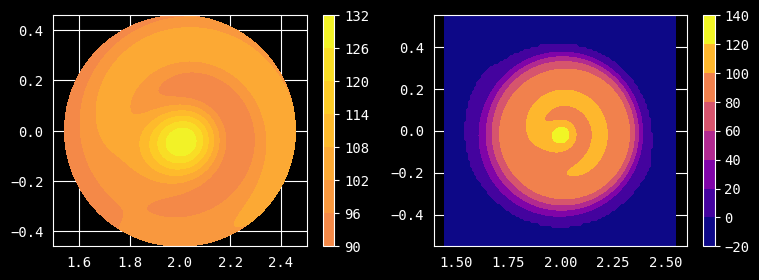

In [473]:
# def calc_g(r, θ, a): # r: array of radii, θ: array of angles, a vector of coefficients (complex numbers)
#     assert a.shape == (M,L)
#     g = np.zeros((len(r), len(θ)), dtype=complex)
#     for m in range(M):
#         xm = bes_zeros(m, L) # zeros of the mth bessel function
#         print(f'xm: {xm}')
#         for l in range(L):
#             gm = a[m,l] * bes(m, xm[l]*r)
#             for i, θi in enumerate(θ):
#                 g[:,i] += gm * np.exp(1j*m*θi)
#     return g/0.459

def calc_g(r, θ, a): # r: array of radii, θ: array of angles, a vector of coefficients (complex numbers)
    assert a.shape == (M,L)
    g = np.zeros((len(r), len(θ)), dtype=complex)
    for m in range(M):
        gm = np.dot(a[m], bes(m, r*bes_zeros(m, L)[:,None]))
        g += gm[:,None] * np.exp(1j*m*θ)
    return np.abs(g).T/MINR

r = np.linspace(0,1,FINESSE)
θ = np.linspace(0,2*π,FINESSE)

g = calc_g(r, θ, a) # calculate the g emissivity map

rr, θθ = np.meshgrid(r, θ) # create a meshgrid of r and θ
print(f'rr.shape: {rr.shape}, θθ.shape: {θθ.shape}')
rθ = np.stack([rr, θθ], axis=-1)
print(f'rθ.shape: {rθ.shape}')

xy = np.zeros_like(rθ) # convert to cartesian coordinates
xy[:,:,0] = rθ[:,:,0] * np.cos(rθ[:,:,1])
xy[:,:,1] = rθ[:,:,0] * np.sin(rθ[:,:,1]+π) # NOTE: for some reason it's flipped (PROBABLY BC IT'S AN IMAGE AND TOP [0,0 IS THE TOP LEFT CORNER])

cbar_min, cbar_max = np.min([g,emiss]), np.max([g,emiss])
xlm, xlM, ylm, ylM = np.min(xy_gt[:,:,0]), np.max(xy_gt[:,:,0]), np.min(xy_gt[:,:,1]), np.max(xy_gt[:,:,1])

plt.figure(figsize=(9,3))
plt.subplot(121)
plt.contourf(xy[:,:,0]+MAJR, xy[:,:,1], g, vmin=cbar_min, vmax=cbar_max)
plt.axis('equal')
# plt.xlim(xlm, xlM); plt.ylim(ylm, ylM)
plt.colorbar()

plt.subplot(122)
plt.contourf(xy_gt[:,:,0], xy_gt[:,:,1], emiss, vmin=cbar_min, vmax=cbar_max)
plt.axis('equal')
# plt.xlim(xlm, xlM); plt.ylim(ylm, ylM)
plt.colorbar()


plt.show()

In [474]:
#[[ 2.405  5.52   8.654 11.792 14.931 18.071 21.212]
# [ 0.     3.832  7.016 10.173 13.324 16.471 19.616]]